# 🎯 Phase E Evaluation and external validation

This notebook validates ComfortScore using external structural indicators that were not used to construct the score.

- External validation is performed using rank based statistics rather than absolute agreement.
- External proxies are noisy, saturating, and measured on heterogeneous scales.
- Rank agreement tests convergent spatial structure, not prediction or causal effect.
- This makes the validation deliberately conservative.

**Purpose**

1. Show a weak diagnostic using early coarse proxies and explain why it fails
2. Move to matched spatial support proxies and test agreement across buffer radii
3. Build an upgraded external composite and report rank agreement with ComfortScore
4. Add an independent policy layer check using LAEI Focus Areas
5. Confirm spatial structure using global Moran I

**Design principles**

- Matched spatial support: proxies are computed inside the same venue buffers used for feature engineering
- Direction stated up front: expected signs are written before results
- Rank based statistics: Spearman and rank percentiles reduce sensitivity to scale and saturation
- Keep weak results: failures are kept as diagnostic evidence with explicit explanation
- Outputs are saved: tables, plots, and a single JSON report for auditability



## E0 Setup

In [1]:
# ============================================================
# E0 Setup
# ============================================================

import os
import sys
import json
from pathlib import Path
from datetime import datetime, timezone

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

def now_utc_iso() -> str:
    return datetime.now(timezone.utc).isoformat()

def ensure_dir(p: Path) -> Path:
    p.mkdir(parents=True, exist_ok=True)
    return p

def safe_numeric(s: pd.Series) -> pd.Series:
    return pd.to_numeric(s, errors="coerce")

def spearman(a: pd.Series, b: pd.Series) -> float:
    return float(pd.Series(a).corr(pd.Series(b), method="spearman"))

def rank_pct(s: pd.Series) -> pd.Series:
    return pd.Series(s).rank(method="average", pct=True)

def print_block(title: str, lines) -> None:
    print("")
    print(str(title))
    for ln in lines:
        print(str(ln))

print("Setup complete")


# This cell initialises containers to track and save all Phase E tables and figures in a reproducible and auditable manner.

PLOT_PATHS = {}
TABLE_PATHS = {}

SECTION_A_TABLES = {}
SECTION_A_PLOTS = {}

Setup complete


### E0.1 Paths and inputs

In [2]:
# ============================================================
# E0.1 Paths and inputs
# ============================================================

NOTEBOOK_DIR = Path(".").resolve()
PROJECT_ROOT = NOTEBOOK_DIR.parent

DATA_DIR = PROJECT_ROOT / "data"
RAW_DIR = DATA_DIR / "raw"
PROCESSED_DIR = DATA_DIR / "processed"
RESULTS_DIR = DATA_DIR / "results"

PLOTS_DIR = ensure_dir(RESULTS_DIR / "validation_plots")
TABLES_DIR = ensure_dir(RESULTS_DIR / "validation_tables")

SCORED_CSV = RESULTS_DIR / "venues_scored.csv"
VENUES_CLEAN = PROCESSED_DIR / "venues_clean.geojson"

PROXY_GREENS_PATH = RAW_DIR / "external_validation_greenspace.csv"
PROXY_ROADS_PATH = RAW_DIR / "external_validation_major_roads.csv"

GREENS_EXTRACT_DIR = RAW_DIR / "os_open_greenspace" / "opgrsp_essh_tq_extracted"
MAJOR_ROADS_GPKG = RAW_DIR / "osm_major_roads" / "major_roads_camden_islington.gpkg"
MAJOR_ROADS_LAYER = "major_roads"

LAEI_DIR = RAW_DIR / "laei_focus_areas"
LAEI_SHP = None
if LAEI_DIR.exists():
    cands = list(LAEI_DIR.rglob("*.shp"))
    LAEI_SHP = cands[0] if cands else None

REPORT_PATH = RESULTS_DIR / "validation_report_phaseE.json"

print_block(
    "Inputs",
    [
        f"scored table: {SCORED_CSV}",
        f"venues geometry: {VENUES_CLEAN}",
        f"initial greenspace proxy csv: {PROXY_GREENS_PATH}",
        f"initial roads proxy csv: {PROXY_ROADS_PATH}",
        f"OS Open Greenspace extract: {GREENS_EXTRACT_DIR}",
        f"major roads gpkg: {MAJOR_ROADS_GPKG}",
        f"LAEI shapefile: {str(LAEI_SHP) if LAEI_SHP else 'missing'}",
    ],
)



Inputs
scored table: /home/sai/test/notebook_test/data/results/venues_scored.csv
venues geometry: /home/sai/test/notebook_test/data/processed/venues_clean.geojson
initial greenspace proxy csv: /home/sai/test/notebook_test/data/raw/external_validation_greenspace.csv
initial roads proxy csv: /home/sai/test/notebook_test/data/raw/external_validation_major_roads.csv
OS Open Greenspace extract: /home/sai/test/notebook_test/data/raw/os_open_greenspace/opgrsp_essh_tq_extracted
major roads gpkg: /home/sai/test/notebook_test/data/raw/osm_major_roads/major_roads_camden_islington.gpkg
LAEI shapefile: /home/sai/test/notebook_test/data/raw/laei_focus_areas/laei_gis/2. GIS files/LAEI2019_FocusAreas.shp


### E0.2 Validation report container

In [3]:
# ============================================================
# E0.2 Validation report container
# Purpose : A single dictionary that every section can write into.
# ============================================================

validation = {
    "created_at_utc": now_utc_iso(),
    "inputs": {
        "scored_table": str(SCORED_CSV),
        "venues_geometry": str(VENUES_CLEAN),
        "initial_greenspace_proxy_csv": str(PROXY_GREENS_PATH),
        "initial_roads_proxy_csv": str(PROXY_ROADS_PATH),
        "os_open_greenspace_extract": str(GREENS_EXTRACT_DIR),
        "major_roads_gpkg": str(MAJOR_ROADS_GPKG),
        "laei_shapefile": str(LAEI_SHP) if LAEI_SHP else None,
    },
    "counts": {},
    "tables": {},
    "plots": {},
    "weak_validation_initial_proxies": {"status": "not_run"},
    "strong_validation_matched_support": {"status": "not_run"},
    "external_composite": {"status": "not_run"},
    "policy_validation_laei": {"status": "not_run"},
    "spatial_structure": {"status": "not_run"},
}

print("validation container ready")


validation container ready


### E0.3 Load scored venues and attach geometry

In [4]:
# ============================================================
# E0.3 Load scored venues and attach geometry
# ============================================================

if not SCORED_CSV.exists():
    raise FileNotFoundError(f"Missing {SCORED_CSV}. Run the scoring notebook first")
if not VENUES_CLEAN.exists():
    raise FileNotFoundError(f"Missing {VENUES_CLEAN}. Run the cleaning notebook first")

df = pd.read_csv(SCORED_CSV)
venues = gpd.read_file(VENUES_CLEAN)

need_cols = ["id", "name", "ComfortScore", "QuietScore", "GreenScore", "CrowdScore", "AccessScore"]
missing = [c for c in need_cols if c not in df.columns]
if missing:
    raise ValueError(f"venues_scored.csv missing columns: {missing}")
if "id" not in venues.columns:
    raise ValueError("venues_clean.geojson must contain id")
if venues.crs is None:
    raise ValueError("venues_clean.geojson must have a CRS")

df_use = df[need_cols].copy()
df_use["id"] = df_use["id"].astype(str)
for c in ["ComfortScore", "QuietScore", "GreenScore", "CrowdScore", "AccessScore"]:
    df_use[c] = safe_numeric(df_use[c])

venues_use = venues[["id", "geometry"]].copy()
venues_use["id"] = venues_use["id"].astype(str)

gdf = venues_use.merge(df_use, on="id", how="inner")
gdf = gpd.GeoDataFrame(gdf, geometry="geometry", crs=venues.crs)

TARGET_CRS = "EPSG:27700"
gdf = gdf.to_crs(TARGET_CRS)

geom_types = gdf.geometry.geom_type.value_counts().to_dict()

print_block(
    "Geometry join summary",
    [
        f"rows in scored table: {len(df_use)}",
        f"rows matched with geometry: {len(gdf)}",
        f"CRS: {gdf.crs}",
        f"geometry types: {geom_types}",
    ],
)

validation["counts"]["n_scored"] = int(len(df_use))
validation["counts"]["n_geocoded"] = int(len(gdf))
validation["counts"]["crs"] = str(gdf.crs)
validation["counts"]["geometry_types"] = geom_types


display(gdf.head())



Geometry join summary
rows in scored table: 1211
rows matched with geometry: 1211
CRS: EPSG:27700
geometry types: {'Polygon': 643, 'Point': 559, 'MultiPolygon': 9}


,id,geometry,name,ComfortScore,QuietScore,GreenScore,CrowdScore,AccessScore
0,13799212,POINT (530835.223 181922.569),Holborn Library,0.430633,0.416740,0.148512,0.536859,1.0
1,25475389,POINT (529873.562 182510.483),Woburn Cafe,0.336945,0.341400,0.104506,0.610577,0.2
2,25497832,POINT (530790.094 182331.853),Cafe Angel,0.425302,0.467686,0.099666,0.783654,0.2
3,248231088,POINT (528356.799 186417.814),Kalendar,0.588720,0.857143,0.117117,0.921474,0.2
4,267971989,POINT (527143.833 187468.195),The Brew House Café,0.579316,0.857143,0.148270,0.858974,0.2


In [5]:
# ============================================================
# Helper function used by Section A and Section B
# ============================================================

from pathlib import Path

def find_greenspace_sites_shp(extract_dir: Path):
    """
    Locate the GreenspaceSite shapefile inside the OS Open Greenspace extract.
    Returns the Path if found, else None.
    """
    if not extract_dir.exists():
        return None

    for p in extract_dir.rglob("*.shp"):
        if "greenspacesite" in p.name.lower():
            return p

    return None

print("GreenspaceSite shapefile helper loaded")


GreenspaceSite shapefile helper loaded


## ✅ E1 Weak validation using initial coarse proxies

**This section is retained deliberately.**
These proxies were an early attempt and they fail for clear reasons. Keeping them provides transparency and supports the methodological decision to move to matched support proxies.

**Expected directions**
- GreenScore should increase with a greenspace proxy.
- QuietScore should increase with a quietness proxy.

**Known limitations of these initial proxies**
- Spatial support mismatch.
- Construct mismatch, for example road distance is not the same as modelled noise exposure.
- Measurement noise and incompleteness.


### E1.1 Generate coarse proxy

In [6]:
# ============================================================
# E1.1 Generate coarse proxy CSVs if missing
# Purpose
# These are deliberately simple, early stage proxies used only as a diagnostic.
# They are NOT the primary external validation because they do not match the
# spatial support of the model features.
#
# Outputs written in the exact loader format expected by Section A:
#   data/raw/external_validation_greenspace.csv
#   data/raw/external_validation_major_roads.csv
#
# Definition of coarse proxies
#   ProxyGreenspace: nearer to a greenspace site boundary is better
#   ProxyRoadDistance: further from a major road line is better
#
# Note:
# We compute distances from a representative point per venue geometry.
# We transform distances into a 0 to 1 score using a smooth decay so that
# results are stable and do not depend on a single hard threshold.
# ============================================================

import numpy as np
import pandas as pd
import geopandas as gpd
from pathlib import Path

TARGET_CRS = "EPSG:27700"

PROXY_GREENS_PATH = RAW_DIR / "external_validation_greenspace.csv"
PROXY_ROADS_PATH  = RAW_DIR / "external_validation_major_roads.csv"

SITES_SHP = find_greenspace_sites_shp(GREENS_EXTRACT_DIR)
if SITES_SHP is None:
    raise FileNotFoundError(
        f"Cannot generate coarse greenspace proxy because GreenspaceSite shapefile was not found in {GREENS_EXTRACT_DIR}"
    )

if not MAJOR_ROADS_GPKG.exists():
    raise FileNotFoundError(
        f"Cannot generate coarse roads proxy because major roads gpkg is missing at {MAJOR_ROADS_GPKG}"
    )

def representative_points(g: gpd.GeoDataFrame) -> gpd.GeoSeries:
    geom = g.geometry
    non_point = geom.geom_type != "Point"
    if bool(non_point.any()):
        geom = geom.copy()
        geom.loc[non_point] = geom.loc[non_point].representative_point()
    return geom

def distance_to_nearest(source_pts: gpd.GeoSeries, target_gdf: gpd.GeoDataFrame) -> np.ndarray:
    """
    Fast nearest distance using spatial join nearest.
    Returns an array aligned with source_pts.
    """
    src = gpd.GeoDataFrame({"_idx": np.arange(len(source_pts))}, geometry=source_pts, crs=TARGET_CRS)
    tgt = target_gdf[["geometry"]].copy()
    joined = gpd.sjoin_nearest(src, tgt, how="left", distance_col="dist_m")
    out = np.full(len(source_pts), np.nan, dtype=float)
    out[joined["_idx"].to_numpy()] = joined["dist_m"].to_numpy(dtype=float)
    return out

def score_from_distance(dist_m: np.ndarray, scale_m: float) -> np.ndarray:
    """
    Convert distance to a 0 to 1 score.
    1 means very near, 0 means very far.
    Smooth decay: score = exp( - d / scale )
    """
    d = dist_m.astype(float)
    out = np.exp(-np.divide(d, float(scale_m)))
    return out

needs_green = not PROXY_GREENS_PATH.exists()
needs_roads = not PROXY_ROADS_PATH.exists()

if not (needs_green or needs_roads):
    print("Coarse proxy CSVs already exist, skipping generation")
else:
    # Venue points for distance calculations
    pts = gdf[["id", "geometry"]].copy()
    pts = pts.set_geometry(representative_points(pts))
    pts = pts.to_crs(TARGET_CRS)

    # Load target layers
    sites = gpd.read_file(SITES_SHP).to_crs(TARGET_CRS)
    sites = sites[sites.geometry.notna() & (~sites.geometry.is_empty)].copy()

    roads = gpd.read_file(MAJOR_ROADS_GPKG, layer=MAJOR_ROADS_LAYER)
    if roads.crs is None:
        roads = roads.set_crs(TARGET_CRS, allow_override=True)
    roads = roads.to_crs(TARGET_CRS)
    roads = roads[roads.geometry.notna() & (~roads.geometry.is_empty)].copy()

    # Compute and save greenspace proxy
    if needs_green:
        dist_g = distance_to_nearest(pts.geometry, sites)
        proxy_g = score_from_distance(dist_g, scale_m=300.0)
        out_g = pd.DataFrame(
            {"id": pts["id"].astype(str).values, "ExternalScore": proxy_g.astype(float)}
        )
        out_g.to_csv(PROXY_GREENS_PATH, index=False)
        print(f"Saved {PROXY_GREENS_PATH} rows {len(out_g)}")

    # Compute and save roads proxy
    if needs_roads:
        dist_r = distance_to_nearest(pts.geometry, roads)
        # For quietness proxy, further from roads is better
        # ProxyRoadDistance is a convenience transform so higher means quieter.
        # It is based on distance to major roads, not on modelled noise exposure,
        # so it cannot validate QuietScore strongly and is kept as a diagnostic only.

        proxy_r = 1.0 - score_from_distance(dist_r, scale_m=150.0)
        out_r = pd.DataFrame(
            {"id": pts["id"].astype(str).values, "ExternalScore": proxy_r.astype(float)}
        )
        out_r.to_csv(PROXY_ROADS_PATH, index=False)
        print(f"Saved {PROXY_ROADS_PATH} rows {len(out_r)}")


Saved /home/sai/test/notebook_test/data/raw/external_validation_greenspace.csv rows 1211
Saved /home/sai/test/notebook_test/data/raw/external_validation_major_roads.csv rows 1211


### E1.2 Coarse proxy coverage and alignment diagnostics

In [7]:
# ============================================================
# E1.2 Coarse proxy coverage and alignment diagnostics
# Purpose
# Make the weakness explicit and measurable:
#   1 Coverage and missingness
#   2 Directional component checks
#   3 Composite check in rank space
#
# Why this is expected to be weak
# These proxies are distance based, while the model features are buffer summaries.
# Distance to nearest feature is not the same as exposure inside the neighbourhood.
# ============================================================

def load_proxy_csv(path: Path, col_name: str) -> pd.DataFrame:
    x = pd.read_csv(path)
    if "id" not in x.columns or "ExternalScore" not in x.columns:
        raise ValueError("Proxy file must contain columns: id, ExternalScore")
    x = x[["id", "ExternalScore"]].copy()
    x["id"] = x["id"].astype(str)
    x[col_name] = safe_numeric(x["ExternalScore"])
    x = x.drop(columns=["ExternalScore"])
    return x

p_green = load_proxy_csv(PROXY_GREENS_PATH, "ProxyGreenspace")
p_roads = load_proxy_csv(PROXY_ROADS_PATH, "ProxyRoadDistance")

base = gdf[["id", "ComfortScore", "GreenScore", "QuietScore"]].copy()
base["id"] = base["id"].astype(str)

m = base.merge(p_green, on="id", how="left").merge(p_roads, on="id", how="left")
n_total = int(len(m))
n_green = int(m["ProxyGreenspace"].notna().sum())
n_roads = int(m["ProxyRoadDistance"].notna().sum())
n_both = int(m[["ProxyGreenspace", "ProxyRoadDistance"]].notna().all(axis=1).sum())

print_block(
    "Coarse proxy coverage",
    [
        f"venues total: {n_total}",
        f"greenspace proxy present: {n_green}  missing {n_total - n_green}",
        f"roads proxy present: {n_roads}  missing {n_total - n_roads}",
        f"both present: {n_both}  missing {n_total - n_both}",
    ],
)

mm = m.dropna(subset=["GreenScore", "QuietScore", "ComfortScore", "ProxyGreenspace", "ProxyRoadDistance"]).copy()

# Component checks in rank space, robust to scaling and saturation
g_rho = spearman(rank_pct(mm["GreenScore"]), rank_pct(mm["ProxyGreenspace"]))
q_rho = spearman(rank_pct(mm["QuietScore"]), rank_pct(mm["ProxyRoadDistance"]))

# External composite in rank space
mm["ComfortRank"] = rank_pct(mm["ComfortScore"])
mm["GreenProxyRank"] = rank_pct(mm["ProxyGreenspace"])
mm["RoadProxyRank"] = rank_pct(mm["ProxyRoadDistance"])
mm["ExternalComposite"] = 0.5 * mm["GreenProxyRank"].to_numpy(dtype=float) + 0.5 * mm["RoadProxyRank"].to_numpy(dtype=float)

c_rho = spearman(mm["ComfortRank"], mm["ExternalComposite"])

validation["weak_validation_initial_proxies"] = {
    "status": "completed",
    "n_total": int(n_total),
    "n_used": int(len(mm)),
    "spearman_rank_green_component": float(g_rho),
    "spearman_rank_quiet_component": float(q_rho),
    "spearman_rank_comfort_vs_coarse_external_composite": float(c_rho),
    "notes": [
        "Distance based proxies are kept as a diagnostic only",
        "They do not match buffer based measurement support",
    ],
}


print_block(
    "Coarse proxy alignment",
    [
        f"rows used: {len(mm)}",
        f"Spearman ranks GreenScore vs greenspace proxy: {g_rho:.3f}  expected positive",
        f"Spearman ranks QuietScore vs roads proxy: {q_rho:.3f}  expected positive",
        f"Spearman ranks ComfortScore vs coarse external composite: {c_rho:.3f}  expected positive",
        "",
        "Interpretation",
        "If component correlations are near zero or wrong sign, it indicates construct mismatch.",
        "This supports replacing distance proxies with matched support proxies inside the same buffers.",
    ],
)



# Save a small table for auditability
OUT_A1 = TABLES_DIR / "coarse_proxy_alignment_summary.csv"
pd.DataFrame(
    [
        {
            "n_total": n_total,
            "n_used": int(len(mm)),
            "spearman_rank_GreenScore_vs_ProxyGreenspace": float(g_rho),
            "spearman_rank_QuietScore_vs_ProxyRoadDistance": float(q_rho),
            "spearman_rank_ComfortScore_vs_coarse_external_composite": float(c_rho),
        }
    ]
).to_csv(OUT_A1, index=False)
validation["tables"]["coarse_proxy_alignment_summary"] = str(OUT_A1)
print("Saved:", OUT_A1)



Coarse proxy coverage
venues total: 1211
greenspace proxy present: 1211  missing 0
roads proxy present: 1211  missing 0
both present: 1211  missing 0

Coarse proxy alignment
rows used: 1211
Spearman ranks GreenScore vs greenspace proxy: 0.055  expected positive
Spearman ranks QuietScore vs roads proxy: 0.182  expected positive
Spearman ranks ComfortScore vs coarse external composite: 0.188  expected positive

Interpretation
If component correlations are near zero or wrong sign, it indicates construct mismatch.
This supports replacing distance proxies with matched support proxies inside the same buffers.
Saved: /home/sai/test/notebook_test/data/results/validation_tables/coarse_proxy_alignment_summary.csv


- These are small effect sizes and distance proxies do not share the same measurement support as buffer based exposure features, so they are treated as a diagnostic not a validation.

### E1.3 Visual evidence of weakness and a short justification

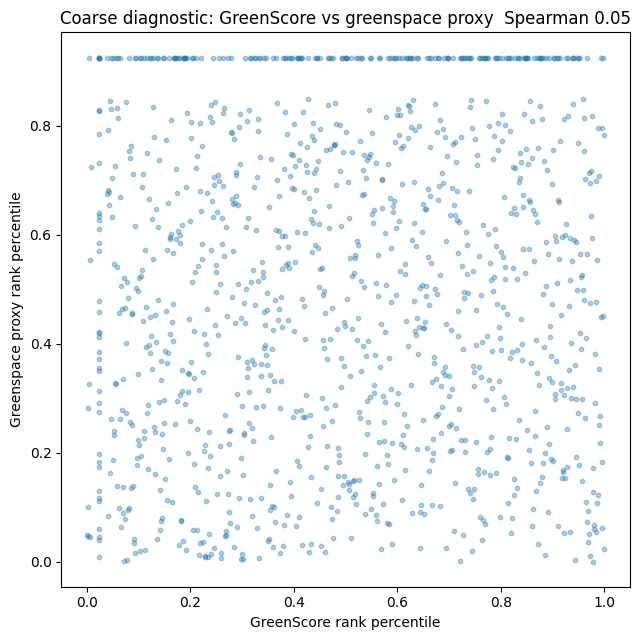

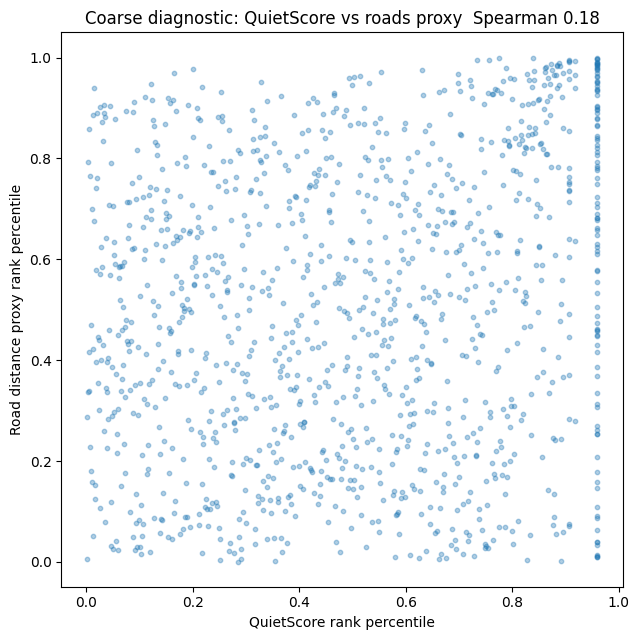

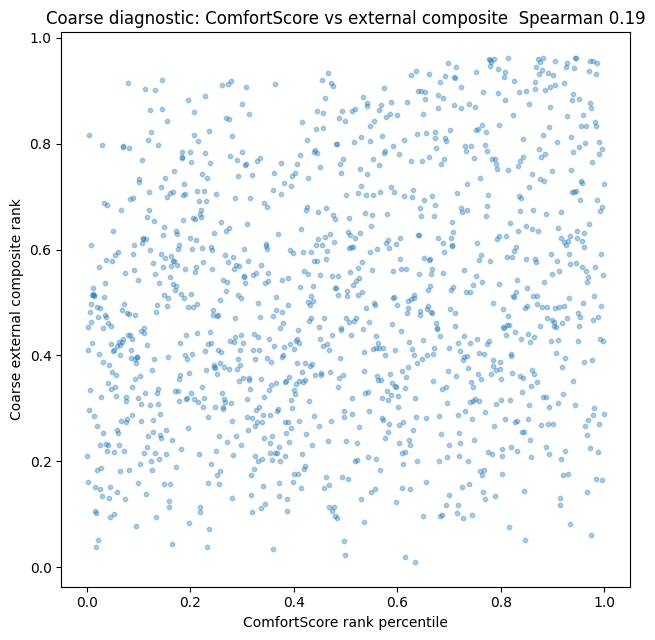

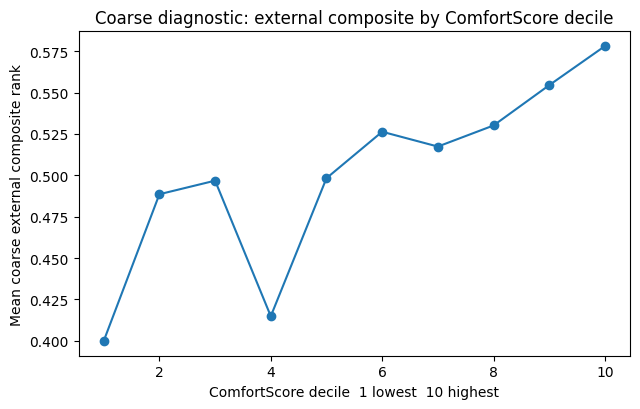

In [8]:
# ============================================================
# E1.3 Visual evidence of weakness plus a short justification
# Purpose
# Show reviewers what the weakness looks like, not just one number:
#   1 Rank scatter plots for each component
#   2 Decile trend for the external composite
#
# Why we do not add many other external datasets here
# External validation datasets must meet three requirements:
#   1 Matched spatial support: measurable inside the same venue buffers
#   2 Reproducible open access: stable download, clear licence, no paywalls
#   3 Construct relevance: measures a compatible structural concept
#
# Many popular datasets fail at least one:
#   StreetView based audits or footfall often require proprietary access and can embed personal data issues
#   Survey based wellbeing is not structural and has different support and sampling
#   High resolution mobility data is typically restricted and not reproducible
#
# Therefore, the primary external validation uses matched support proxies that we can reproduce fully:
#   OS Open Greenspace polygons inside buffers
#   OSM major roads geometry inside buffers
# ============================================================

def rank_scatter(x: pd.Series, y: pd.Series, title: str, xlab: str, ylab: str, out_png: Path):
    plt.figure(figsize=(6.5, 6.5))
    plt.scatter(x, y, s=10, alpha=0.35)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title)
    plt.tight_layout()
    plt.savefig(out_png, dpi=250)
    plt.show()
    return out_png

# Rank scatter evidence for components
out1 = PLOTS_DIR / "coarse_rank_scatter_green_component.png"
out2 = PLOTS_DIR / "coarse_rank_scatter_quiet_component.png"
out3 = PLOTS_DIR / "coarse_rank_scatter_external_composite.png"

rank_scatter(
    rank_pct(mm["GreenScore"]),
    rank_pct(mm["ProxyGreenspace"]),
    f"Coarse diagnostic: GreenScore vs greenspace proxy  Spearman {g_rho:.2f}",
    "GreenScore rank percentile",
    "Greenspace proxy rank percentile",
    out1,
)

rank_scatter(
    rank_pct(mm["QuietScore"]),
    rank_pct(mm["ProxyRoadDistance"]),
    f"Coarse diagnostic: QuietScore vs roads proxy  Spearman {q_rho:.2f}",
    "QuietScore rank percentile",
    "Road distance proxy rank percentile",
    out2,
)

rank_scatter(
    mm["ComfortRank"],
    mm["ExternalComposite"],
    f"Coarse diagnostic: ComfortScore vs external composite  Spearman {c_rho:.2f}",
    "ComfortScore rank percentile",
    "Coarse external composite rank",
    out3,
)


# Decile trend evidence
tmp = mm.copy()
tmp["ComfortDecile"] = pd.qcut(tmp["ComfortRank"], q=10, labels=False, duplicates="drop").astype(int) + 1
trend = tmp.groupby("ComfortDecile", as_index=False).agg(
    n=("id", "size"),
    external_comp_mean=("ExternalComposite", "mean"),
)

plt.figure(figsize=(6.5, 4.2))
plt.plot(trend["ComfortDecile"], trend["external_comp_mean"], marker="o")
plt.xlabel("ComfortScore decile  1 lowest  10 highest")
plt.ylabel("Mean coarse external composite rank")
plt.title("Coarse diagnostic: external composite by ComfortScore decile")
plt.tight_layout()
out4 = PLOTS_DIR / "coarse_external_composite_by_decile.png"
plt.savefig(out4, dpi=250)
plt.show()

validation["plots"]["coarse_rank_scatter_green"] = str(out1)
validation["plots"]["coarse_rank_scatter_quiet"] = str(out2)
validation["plots"]["coarse_rank_scatter_composite"] = str(out3)
validation["plots"]["coarse_external_composite_by_decile"] = str(out4)




In [9]:
print_block(
    "Coarse diagnostic conclusion",
    [
        "These plots and correlations are intentionally retained even when weak.",
        "They demonstrate that naive distance based proxies do not validate buffer based exposure features.",
        "This motivates the matched support validation as the primary external validation strategy.",
    ],
)


Coarse diagnostic conclusion
These plots and correlations are intentionally retained even when weak.
They demonstrate that naive distance based proxies do not validate buffer based exposure features.
This motivates the matched support validation as the primary external validation strategy.


### E1.4Falsification baseline for coarse proxies

In [10]:
# ============================================================
# E1.4Falsification baseline for coarse proxies
# Purpose
# Show that any apparent alignment in Section A is not a numerical artefact.
# We shuffle the proxy values across venues and recompute the same rank correlations.
# Expected result: correlations collapse to ~0 after shuffling.
#
# Where to add this
# Place this cell immediately after A1 (after you compute g_rho, q_rho, c_rho and create mm).
# It uses: mm, g_rho, q_rho, c_rho, spearman, rank_pct
# ============================================================

import numpy as np
import pandas as pd

rng = np.random.default_rng(42)

# Keep only what we need from mm
mm_f = mm[["GreenScore", "QuietScore", "ComfortScore", "ProxyGreenspace", "ProxyRoadDistance"]].copy()

# Shuffle proxies across rows (break the link between venue and proxy)
shuf_green = mm_f["ProxyGreenspace"].to_numpy(dtype=float).copy()
shuf_roads = mm_f["ProxyRoadDistance"].to_numpy(dtype=float).copy()
rng.shuffle(shuf_green)
rng.shuffle(shuf_roads)

mm_f["ProxyGreenspace_shuf"] = shuf_green
mm_f["ProxyRoadDistance_shuf"] = shuf_roads

# Recompute the same rank based checks on shuffled proxies
g_rho_shuf = spearman(rank_pct(mm_f["GreenScore"]), rank_pct(mm_f["ProxyGreenspace_shuf"]))
q_rho_shuf = spearman(rank_pct(mm_f["QuietScore"]), rank_pct(mm_f["ProxyRoadDistance_shuf"]))

mm_f["ComfortRank"] = rank_pct(mm_f["ComfortScore"])
mm_f["GreenProxyRank_shuf"] = rank_pct(mm_f["ProxyGreenspace_shuf"])
mm_f["RoadProxyRank_shuf"] = rank_pct(mm_f["ProxyRoadDistance_shuf"])
mm_f["ExternalComposite_shuf"] = (
    0.5 * mm_f["GreenProxyRank_shuf"].to_numpy(dtype=float)
    + 0.5 * mm_f["RoadProxyRank_shuf"].to_numpy(dtype=float)
)

c_rho_shuf = spearman(mm_f["ComfortRank"], mm_f["ExternalComposite_shuf"])

validation["weak_validation_initial_proxies"]["falsification"] = {
    "spearman_rank_green_shuffled": float(g_rho_shuf),
    "spearman_rank_quiet_shuffled": float(q_rho_shuf),
    "spearman_rank_composite_shuffled": float(c_rho_shuf),
}


print_block(
    "Coarse proxy falsification baseline",
    [
        f"Observed Spearman ranks GreenScore vs greenspace proxy: {g_rho:.3f}",
        f"Shuffled Spearman ranks GreenScore vs greenspace proxy: {g_rho_shuf:.3f}",
        "",
        f"Observed Spearman ranks QuietScore vs roads proxy: {q_rho:.3f}",
        f"Shuffled Spearman ranks QuietScore vs roads proxy: {q_rho_shuf:.3f}",
        "",
        f"Observed Spearman ranks ComfortScore vs coarse external composite: {c_rho:.3f}",
        f"Shuffled Spearman ranks ComfortScore vs shuffled coarse composite: {c_rho_shuf:.3f}",
        "",
        "Interpretation",
        "If the shuffled values are near zero, the observed correlations reflect real structure,",
        "but the small effect sizes still indicate that distance proxies are a weak diagnostic.",
    ],
)

# Save for auditability
OUT_A3 = TABLES_DIR / "coarse_proxy_falsification_baseline.csv"
pd.DataFrame(
    [
        {
            "spearman_rank_GreenScore_vs_ProxyGreenspace_observed": float(g_rho),
            "spearman_rank_GreenScore_vs_ProxyGreenspace_shuffled": float(g_rho_shuf),
            "spearman_rank_QuietScore_vs_ProxyRoadDistance_observed": float(q_rho),
            "spearman_rank_QuietScore_vs_ProxyRoadDistance_shuffled": float(q_rho_shuf),
            "spearman_rank_ComfortScore_vs_coarse_composite_observed": float(c_rho),
            "spearman_rank_ComfortScore_vs_coarse_composite_shuffled": float(c_rho_shuf),
            "n_used": int(len(mm_f)),
        }
    ]
).to_csv(OUT_A3, index=False)

validation["tables"]["coarse_proxy_falsification_baseline"] = str(OUT_A3)




Coarse proxy falsification baseline
Observed Spearman ranks GreenScore vs greenspace proxy: 0.055
Shuffled Spearman ranks GreenScore vs greenspace proxy: 0.019

Observed Spearman ranks QuietScore vs roads proxy: 0.182
Shuffled Spearman ranks QuietScore vs roads proxy: -0.012

Observed Spearman ranks ComfortScore vs coarse external composite: 0.188
Shuffled Spearman ranks ComfortScore vs shuffled coarse composite: -0.029

Interpretation
If the shuffled values are near zero, the observed correlations reflect real structure,
but the small effect sizes still indicate that distance proxies are a weak diagnostic.


## ✅ E2: Strong External Validation using Matched Spatial Support Proxies

**Overview**
Section E1 used coarse distance proxies as a weak diagnostic. **This section provides primary external validation** by testing GreenScore and QuietScore against external datasets measured within the same venue buffers used in feature engineering.

**External Data Sources**
1. **OS Open Greenspace** - GreenspaceSite polygons
2. **OpenStreetMap** - Major roads geometry (cached locally)

**Computed Metrics (per venue & radius)**
- Greenspace fraction inside buffer
- Major road length density inside buffer  
- Quietness proxy derived from road density rank (higher = quieter)

**Validation Tests**
For each radius, compute **Spearman correlation** on rank percentiles:
- GreenScore vs. greenspace proxy
- QuietScore vs. road quietness proxy




### E2.1 Locate and load matched support layers

In [11]:
# ============================================================
# E2.1 Locate and load matched support layers
# Purpose
# Load the two external layers used for matched support validation
#   1 OS Open Greenspace GreenspaceSite polygons
#   2 OSM major roads geometry (cached gpkg)
#
# Matched support means we can measure proxies inside the same venue buffers
# used in feature engineering, making this a stronger validation than Section A.
# ============================================================

matched_ok = True
missing_reasons = []

sites_path = find_greenspace_sites_shp(GREENS_EXTRACT_DIR)
if sites_path is None:
    matched_ok = False
    missing_reasons.append(
        f"GreenspaceSite shapefile not found inside {GREENS_EXTRACT_DIR}"
    )

if not MAJOR_ROADS_GPKG.exists():
    matched_ok = False
    missing_reasons.append(
        f"Major roads gpkg missing at {MAJOR_ROADS_GPKG}"
    )

if not matched_ok:
    validation["strong_validation_matched_support"] = {
        "status": "skipped",
        "reasons": missing_reasons,
        "extract_dir": str(GREENS_EXTRACT_DIR),
        "major_roads_gpkg": str(MAJOR_ROADS_GPKG),
    }
    print_block("Matched support inputs missing", missing_reasons)

else:
    sites = gpd.read_file(sites_path)
    if sites.crs is None:
        raise ValueError("Greenspace sites file has no CRS")

    sites_m = sites.to_crs(TARGET_CRS)
    sites_m = sites_m[sites_m.geometry.notna() & (~sites_m.geometry.is_empty)].copy()

    roads = gpd.read_file(MAJOR_ROADS_GPKG, layer=MAJOR_ROADS_LAYER)
    if roads.crs is None:
        # If cached layer was saved without CRS metadata, assume British National Grid
        roads = roads.set_crs(TARGET_CRS, allow_override=True)

    roads_m = roads.to_crs(TARGET_CRS)
    roads_m = roads_m[roads_m.geometry.notna() & (~roads_m.geometry.is_empty)].copy()

    sites_sidx = sites_m.sindex
    roads_sidx = roads_m.sindex

    validation["strong_validation_matched_support"] = {
        "status": "inputs_loaded",
        "datasets": {
            "greenspace_sites_shp": str(sites_path),
            "major_roads_gpkg": str(MAJOR_ROADS_GPKG),
            "major_roads_layer": str(MAJOR_ROADS_LAYER),
        },
        "counts": {
            "greenspace_polygons": int(len(sites_m)),
            "major_roads_features": int(len(roads_m)),
        },
    }

    print_block(
        "Matched support layers loaded",
        [
            f"greenspace sites shp: {sites_path}",
            f"greenspace polygons: {len(sites_m)}",
            f"major roads features: {len(roads_m)}",
        ],
    )



Matched support layers loaded
greenspace sites shp: /home/sai/test/notebook_test/data/raw/os_open_greenspace/opgrsp_essh_tq_extracted/data/TQ_GreenspaceSite.shp
greenspace polygons: 21928
major roads features: 12321


### E2.2 Compute matched support proxies inside venue buffers

In [12]:
# ============================================================
# E2.2 Compute matched support proxies inside venue buffers
# ============================================================

"""
We compute two proxies inside the same buffer radii used in feature engineering.

Greenspace fraction
Area of greenspace polygons intersecting the buffer divided by buffer area.

Major road length density
Total length of major road lines intersecting the buffer divided by buffer area.

Quietness proxy from roads
Higher road density implies less quiet.
We convert this into a quietness proxy using the rank of negative road density, so higher is quieter.
This is still not modelled noise exposure, but it is matched in spatial support and therefore a better proxy.
"""

RADII_M = [100, 300, 500]

def greenspace_fraction(points: gpd.GeoDataFrame, radius_m: int) -> pd.Series:
    bufs = points.geometry.buffer(float(radius_m))
    out = np.zeros(len(points), dtype=float)

    for i, buf in enumerate(bufs):
        cand_idx = list(sites_sidx.intersection(buf.bounds))
        if not cand_idx:
            out[i] = 0.0
            continue
        cand = sites_m.iloc[cand_idx]
        inter_area = cand.geometry.intersection(buf).area.sum()
        denom = float(buf.area)
        out[i] = float(inter_area / denom) if denom > 0 else 0.0

    return pd.Series(out, index=points.index)

def road_length_density(points: gpd.GeoDataFrame, radius_m: int) -> pd.Series:
    bufs = points.geometry.buffer(float(radius_m))
    out = np.zeros(len(points), dtype=float)

    for i, buf in enumerate(bufs):
        cand_idx = list(roads_sidx.intersection(buf.bounds))
        if not cand_idx:
            out[i] = 0.0
            continue
        cand = roads_m.iloc[cand_idx]
        inter_len = cand.geometry.intersection(buf).length.sum()
        denom = float(buf.area)
        out[i] = float(inter_len / denom) if denom > 0 else 0.0

    return pd.Series(out, index=points.index)

proxy_df = pd.DataFrame({"id": gdf["id"].astype(str)})

for r in RADII_M:
    frac = greenspace_fraction(gdf, r)
    dens = road_length_density(gdf, r)

    proxy_df[f"GreenspaceFrac_{r}m"] = frac.astype(float)
    proxy_df[f"MajorRoadLenDens_{r}m"] = dens.astype(float)

    proxy_df[f"GreenProxyRank_{r}m"] = rank_pct(frac)

    # Quietness proxy  higher is quieter
    proxy_df[f"RoadQuietProxyRank_{r}m"] = rank_pct(np.negative(dens.to_numpy(dtype=float)))

OUT_PROXY_TABLE = RAW_DIR / "external_validation_upgraded_buffers.csv"
proxy_df.to_csv(OUT_PROXY_TABLE, index=False)

validation["tables"]["matched_support_proxy_table"] = str(OUT_PROXY_TABLE)

print_block(
    "Matched support proxy table saved",
    [
        f"path: {OUT_PROXY_TABLE}",
        f"rows: {len(proxy_df)}",
        f"radii: {RADII_M}",
    ],
)



Matched support proxy table saved
path: /home/sai/test/notebook_test/data/raw/external_validation_upgraded_buffers.csv
rows: 1211
radii: [100, 300, 500]


### E2.3 Agreement by radius and selection of best radius

In [13]:
# ============================================================
# E2.3 Agreement by radius and selection of best radius
# ============================================================

"""
We quantify agreement in rank space across radii.

We report
1 GreenScore vs greenspace proxy rank
2 QuietScore vs road quietness proxy rank

We choose the best radius as the one that maximises the sum of absolute component correlations.
This is a simple, transparent rule and avoids tuning on the final composite directly.
"""

if not matched_ok:
    reasons = validation.get("strong_validation_matched_support", {}).get("reasons", ["matched inputs missing"])
    print_block("Matched support validation skipped", reasons)
else:
    base = gdf[["id", "ComfortScore", "GreenScore", "QuietScore"]].copy()
    base["id"] = base["id"].astype(str)

    merged = base.merge(proxy_df, on="id", how="inner").dropna()

    rows = []
    for r in RADII_M:
        g_proxy = merged[f"GreenProxyRank_{r}m"]
        q_proxy = merged[f"RoadQuietProxyRank_{r}m"]

        g_s = spearman(rank_pct(merged["GreenScore"]), g_proxy)
        q_s = spearman(rank_pct(merged["QuietScore"]), q_proxy)

        rows.append(
            {
                "radius_m": int(r),
                "spearman_rank_GreenScore_vs_GreenProxy": float(g_s),
                "spearman_rank_QuietScore_vs_RoadQuietProxy": float(q_s),
            }
        )

    summary = pd.DataFrame(rows).sort_values("radius_m").reset_index(drop=True)
    summary["abs_target_sum"] = (
        np.abs(summary["spearman_rank_GreenScore_vs_GreenProxy"].to_numpy(dtype=float))
        + np.abs(summary["spearman_rank_QuietScore_vs_RoadQuietProxy"].to_numpy(dtype=float))
    )

    best_r = int(summary.sort_values("abs_target_sum", ascending=False).iloc[0]["radius_m"])

    OUT_SUMMARY = TABLES_DIR / "matched_support_spearman_by_radius.csv"
    summary.to_csv(OUT_SUMMARY, index=False)

    validation["tables"]["matched_support_spearman_by_radius"] = str(OUT_SUMMARY)
    validation["strong_validation_matched_support"] = {
        "status": "completed",
        "n": int(len(merged)),
        "radii_m": [int(x) for x in RADII_M],
        "table": summary.to_dict(orient="records"),
        "best_radius_selected_m": int(best_r),
        "datasets": {
            "greenspace_sites_shp": str(sites_path),
            "major_roads_gpkg": str(MAJOR_ROADS_GPKG),
        },
        "expected_direction": {
            "GreenScore_vs_GreenProxy": "positive",
            "QuietScore_vs_RoadQuietProxy": "positive",
        },
    }

    print_block(
        "Matched support validation summary",
        [
            f"rows: {len(merged)}",
            f"best radius selected: {best_r} m",
            f"saved table: {OUT_SUMMARY}",
        ],
    )

    display(summary)



Matched support validation summary
rows: 1211
best radius selected: 500 m
saved table: /home/sai/test/notebook_test/data/results/validation_tables/matched_support_spearman_by_radius.csv


,radius_m,spearman_rank_GreenScore_vs_GreenProxy,spearman_rank_QuietScore_vs_RoadQuietProxy,abs_target_sum
0,100,0.063993,0.302583,0.366576
1,300,0.067170,0.591420,0.658590
2,500,0.168897,0.503004,0.671901


### E2.4 Plot component alignment by radius for the dissertation

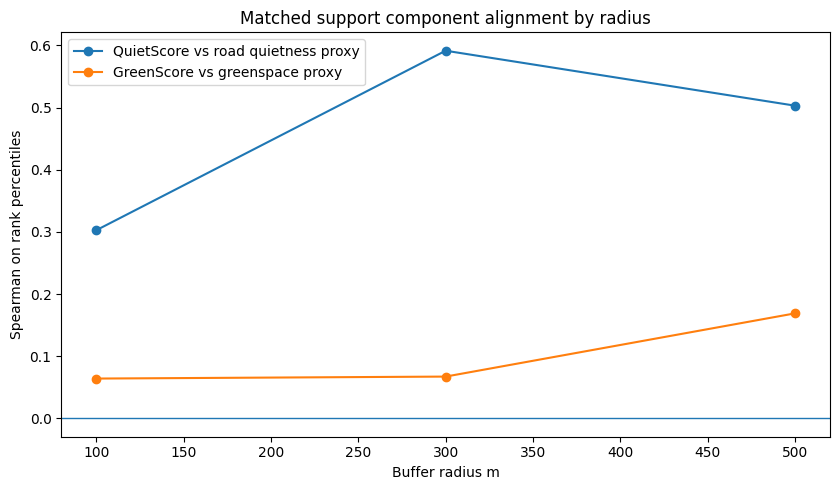

Saved: /home/sai/test/notebook_test/data/results/validation_plots/matched_support_component_alignment_by_radius.png


In [14]:
# ============================================================
# E2.4 Plot component alignment by radius for the dissertation
# ============================================================

if not matched_ok:
    pass
else:
    fig = plt.figure(figsize=(8.5, 5))
    ax = plt.gca()

    ax.plot(
        summary["radius_m"],
        summary["spearman_rank_QuietScore_vs_RoadQuietProxy"],
        marker="o",
        label="QuietScore vs road quietness proxy",
    )
    ax.plot(
        summary["radius_m"],
        summary["spearman_rank_GreenScore_vs_GreenProxy"],
        marker="o",
        label="GreenScore vs greenspace proxy",
    )

    ax.axhline(0.0, linewidth=1)
    ax.set_xlabel("Buffer radius m")
    ax.set_ylabel("Spearman on rank percentiles")
    ax.set_title("Matched support component alignment by radius")
    ax.legend()

    out_png = PLOTS_DIR / "matched_support_component_alignment_by_radius.png"
    plt.tight_layout()
    plt.savefig(out_png, dpi=250)
    plt.show()

    validation["plots"]["matched_support_component_alignment_by_radius"] = str(out_png)
    print("Saved:", out_png)


## ✅ E3 Upgraded External Composite and Rank Agreement

**Purpose**

- Construct a single upgraded external comparator for ComfortScore using independent proxies measured on the same matched spatial support.

**Why this matters**

- ComfortScore is a composite index and is not expected to align strongly with any single proxy. A more defensible convergent check is to compare it against an external composite built from independent datasets on identical spatial support.

**Method**

1. Select the buffer radius based on Section B where component alignment is strongest  
2. Build **ExternalCompositeUpgraded** as an equal weight average of proxy rank scores at that radius  
3. Compare ComfortScore rank with ExternalCompositeUpgraded rank using Spearman correlation  
4. Add a falsification baseline by shuffling the external composite  
5. Save a reusable rank table and a scatter plot for reporting and review


###  E3.1 Build upgraded external composite at selected radius

In [15]:
# ============================================================
# E3.1 Build upgraded external composite at selected radius
# ============================================================

if not matched_ok:
    validation["external_composite"] = {
        "status": "skipped",
        "reason": "matched support inputs missing in Section B",
    }
    print_block("Section C skipped", [validation["external_composite"]["reason"]])

else:
    # Radius selection
    # Prefer best_r from Section B, else default to 300 m
    try:
        best_r = int(best_r)
    except Exception:
        best_r = int(validation.get("strong_validation_matched_support", {}).get("best_radius_selected_m", 300))

    need_cols = [f"GreenProxyRank_{best_r}m", f"RoadQuietProxyRank_{best_r}m"]
    miss = [c for c in need_cols if c not in proxy_df.columns]
    if miss:
        raise ValueError(f"proxy_df missing required columns for radius {best_r}: {miss}")

    comp = gdf[["id", "ComfortScore"]].copy()
    comp["id"] = comp["id"].astype(str)

    comp = comp.merge(
        proxy_df[["id"] + need_cols].copy(),
        on="id",
        how="inner",
    ).dropna()

    # Work in rank space because both sides are ordinal by design
    comp["ComfortRank"] = rank_pct(comp["ComfortScore"])
    comp["ExternalCompositeUpgraded"] = (
        0.5 * comp[need_cols[0]].to_numpy(dtype=float)
        + 0.5 * comp[need_cols[1]].to_numpy(dtype=float)
    )

    rho = spearman(comp["ComfortRank"], comp["ExternalCompositeUpgraded"])

    # Falsification baseline: shuffle composite across venues
    rng = np.random.default_rng(42)
    shuf = comp["ExternalCompositeUpgraded"].to_numpy(dtype=float).copy()
    rng.shuffle(shuf)
    rho_shuf = spearman(comp["ComfortRank"], pd.Series(shuf, index=comp.index))

    validation["external_composite"] = {
        "status": "completed",
        "radius_m": int(best_r),
        "n": int(len(comp)),
        "construction": "0.5 * GreenProxyRank + 0.5 * RoadQuietProxyRank at selected radius",
        "spearman_rank_comfort_vs_external_composite": float(rho),
        "falsification_spearman_rank_shuffled": float(rho_shuf),
        "expected_direction": "positive",
        "notes": [
            "This is convergent validity in ordinal space, not a calibration of absolute accuracy.",
            "The composite uses matched support proxies, but it still does not directly observe noise exposure or subjective comfort.",
        ],
    }

    print_block(
        "Upgraded external composite summary",
        [
            f"radius selected: {best_r} m",
            f"rows used: {len(comp)}",
            f"Spearman rank (ComfortRank vs ExternalCompositeUpgraded): {rho:.3f}",
            f"Falsification Spearman after shuffle: {rho_shuf:.3f}",
        ],
    )

    # Save a reusable table
    out_tbl = pd.DataFrame(
        {
            "id": comp["id"].astype(str).values,
            "ComfortScore": comp["ComfortScore"].astype(float).values,
            "ComfortPercentile": comp["ComfortRank"].astype(float).values,
            "ExternalComposite": comp["ExternalCompositeUpgraded"].astype(float).values,
            "ExternalCompositePercentile": rank_pct(comp["ExternalCompositeUpgraded"]).astype(float).values,
        }
    )

    OUT_CSV = TABLES_DIR / f"external_composite_rank_table_{best_r}m.csv"
    out_tbl.to_csv(OUT_CSV, index=False)
    TABLE_PATHS[f"external_composite_rank_table_{best_r}m"] = str(OUT_CSV)

    print("Saved table:", OUT_CSV)



Upgraded external composite summary
radius selected: 500 m
rows used: 1211
Spearman rank (ComfortRank vs ExternalCompositeUpgraded): 0.537
Falsification Spearman after shuffle: 0.016
Saved table: /home/sai/test/notebook_test/data/results/validation_tables/external_composite_rank_table_500m.csv


### E3.2 Visual evidence: percentile scatter and decile trend

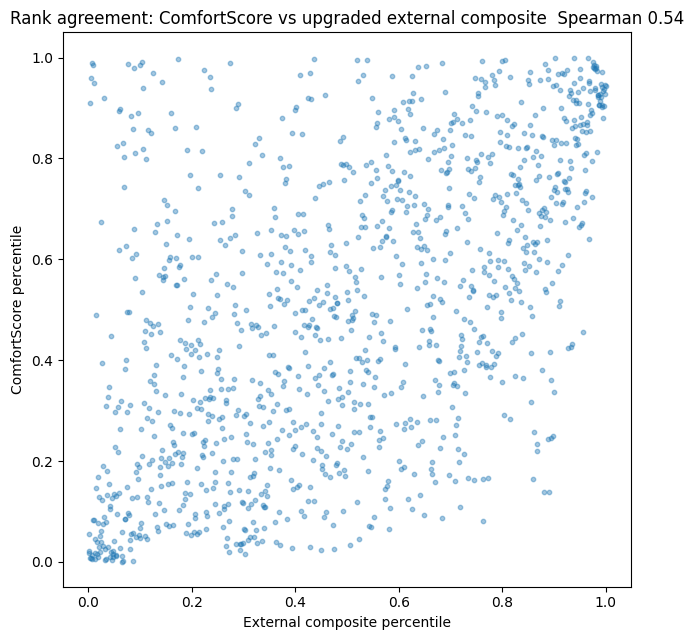

Saved plot: /home/sai/test/notebook_test/data/results/validation_plots/rank_percentile_scatter_external_vs_comfort_500m.png


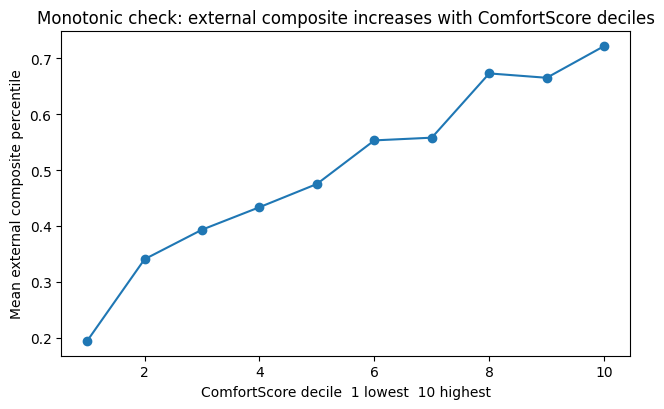

Saved plot: /home/sai/test/notebook_test/data/results/validation_plots/external_composite_by_comfort_decile_500m.png
Saved table: /home/sai/test/notebook_test/data/results/validation_tables/external_composite_by_comfort_decile_500m.csv


In [16]:
# ============================================================
# E3.2 Visual evidence: percentile scatter and decile trend
# Purpose
# Give reviewers visual intuition beyond a single correlation.
# ============================================================

if validation.get("external_composite", {}).get("status") != "completed":
    print_block("Section C plots skipped", ["External composite not available"])
else:
    best_r = int(validation["external_composite"]["radius_m"])

    # Reload from saved table for reproducibility
    tbl_key = f"external_composite_rank_table_{best_r}m"
    if tbl_key not in TABLE_PATHS:
        raise ValueError("External composite rank table path not found in TABLE_PATHS")

    out_tbl = pd.read_csv(TABLE_PATHS[tbl_key])

    rho = float(validation["external_composite"]["spearman_rank_comfort_vs_external_composite"])

    # Scatter plot
    plt.figure(figsize=(6.5, 6.5))
    plt.scatter(out_tbl["ExternalCompositePercentile"], out_tbl["ComfortPercentile"], s=10, alpha=0.4)
    plt.xlabel("External composite percentile")
    plt.ylabel("ComfortScore percentile")
    plt.title(f"Rank agreement: ComfortScore vs upgraded external composite  Spearman {rho:.2f}")
    plt.tight_layout()

    out_png1 = PLOTS_DIR / f"rank_percentile_scatter_external_vs_comfort_{best_r}m.png"
    plt.savefig(out_png1, dpi=250)
    plt.show()

    PLOT_PATHS[f"rank_percentile_scatter_external_vs_comfort_{best_r}m"] = str(out_png1)
    print("Saved plot:", out_png1)

    # Decile trend plot
    tmp = out_tbl.copy()
    tmp["ComfortDecile"] = pd.qcut(tmp["ComfortPercentile"], q=10, labels=False, duplicates="drop").astype(int) + 1
    trend = tmp.groupby("ComfortDecile", as_index=False).agg(
        n=("id", "size"),
        external_mean=("ExternalCompositePercentile", "mean"),
    )

    plt.figure(figsize=(6.5, 4.2))
    plt.plot(trend["ComfortDecile"], trend["external_mean"], marker="o")
    plt.xlabel("ComfortScore decile  1 lowest  10 highest")
    plt.ylabel("Mean external composite percentile")
    plt.title("Monotonic check: external composite increases with ComfortScore deciles")
    plt.tight_layout()

    out_png2 = PLOTS_DIR / f"external_composite_by_comfort_decile_{best_r}m.png"
    plt.savefig(out_png2, dpi=250)
    plt.show()

    PLOT_PATHS[f"external_composite_by_comfort_decile_{best_r}m"] = str(out_png2)
    print("Saved plot:", out_png2)

    # Save trend table too
    out_csv = TABLES_DIR / f"external_composite_by_comfort_decile_{best_r}m.csv"
    trend.to_csv(out_csv, index=False)
    TABLE_PATHS[f"external_composite_by_comfort_decile_{best_r}m"] = str(out_csv)
    print("Saved table:", out_csv)


### E3.3 Explanation

In [17]:
# ============================================================
# E3.3 Interpretation text lines for Results
# ============================================================

if validation.get("external_composite", {}).get("status") != "completed":
    print_block("Section C interpretation", ["External composite not available"])
else:
    ec = validation["external_composite"]
    lines = [
        "Section E3 provides a convergent validity check for the composite index.",
        f"An upgraded external composite was constructed from matched support proxy ranks at {ec['radius_m']} m.",
        f"ComfortScore rank agreement with the upgraded composite is Spearman {ec['spearman_rank_comfort_vs_external_composite']:.3f}.",
        f"A falsification baseline confirms the signal is not mechanical: shuffling yields Spearman {ec['falsification_spearman_rank_shuffled']:.3f}.",
        "This supports ordinal consistency with independent structural indicators, without claiming pointwise accuracy.",
    ]
    print_block("Explanation:", lines)



Explanation:
Section E3 provides a convergent validity check for the composite index.
An upgraded external composite was constructed from matched support proxy ranks at 500 m.
ComfortScore rank agreement with the upgraded composite is Spearman 0.537.
A falsification baseline confirms the signal is not mechanical: shuffling yields Spearman 0.016.
This supports ordinal consistency with independent structural indicators, without claiming pointwise accuracy.


## ✅ E4 Policy layer convergent check using LAEI 2019 Focus Areas

**What this section does**

This section checks whether **ComfortScore** is systematically lower in places flagged by an independent London policy dataset: **LAEI 2019 Air Quality Focus Areas**.

**Why we include this**

LAEI focus areas were not used to build ComfortScore and they represent a policy relevant layer linked to environmental stress and exposure. This is not a component matched proxy for noise or greenness, so we treat it as a **convergent policy check** rather than a strict validation.

**How it works**

1. Load the LAEI Focus Areas polygon layer and ensure it is in the same CRS as the venues.
2. Convert venue geometries to representative points where needed and test whether each venue falls inside a focus area.
3. Compare ComfortScore distributions for venues inside versus outside focus areas using robust summaries:
   - medians and median difference
   - a Mann Whitney U test if SciPy is available
   - an effect size estimate using Cliff delta
4. Save a plot and a small CSV summary table for auditability.


###  E4.1 Helpers for LAEI policy check

In [18]:
# ============================================================
# E4.1 Helpers for LAEI policy check
# ============================================================

def infer_crs_from_bounds(bounds) -> str:
    minx, miny, maxx, maxy = [float(x) for x in bounds]
    # EPSG:4326 typical lon lat ranges
    if (abs(minx) <= 200.0) and (abs(maxx) <= 200.0) and (abs(miny) <= 100.0) and (abs(maxy) <= 100.0):
        return "EPSG:4326"
    return "EPSG:27700"

def representative_points_series(geom: gpd.GeoSeries) -> gpd.GeoSeries:
    non_point = geom.geom_type != "Point"
    if bool(non_point.any()):
        geom = geom.copy()
        geom.loc[non_point] = geom.loc[non_point].representative_point()
    return geom

def mann_whitney_p(a: np.ndarray, b: np.ndarray):
    try:
        from scipy.stats import mannwhitneyu
        a = a[np.isfinite(a)]
        b = b[np.isfinite(b)]
        if len(a) < 10 or len(b) < 10:
            return None
        return float(mannwhitneyu(a, b, alternative="two_sided").pvalue)
    except Exception:
        return None

def cliffs_delta(a: np.ndarray, b: np.ndarray):
    a = a[np.isfinite(a)]
    b = b[np.isfinite(b)]
    if len(a) < 10 or len(b) < 10:
        return None
    gt = 0
    lt = 0
    for x in a:
        gt += int(np.sum(x > b))
        lt += int(np.sum(x < b))
    denom = len(a) * len(b)
    if denom == 0:
        return None
    return float((gt - lt) / denom)


### E4.2 LAEI Focus Areas policy layer check

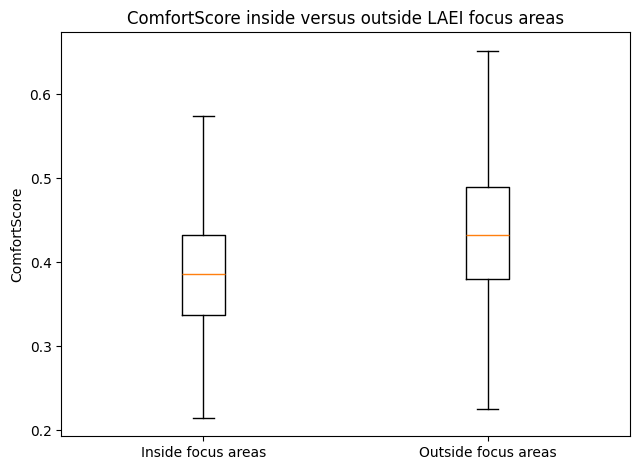


LAEI policy validation summary
venues total: 1211
n inside: 332  n outside: 879
median outside: 0.433
median inside: 0.387
median difference (outside minus inside): 0.046
mann whitney p: NA
cliff delta: 0.3405773263703277
saved plot: /home/sai/test/notebook_test/data/results/validation_plots/laei_inside_outside_boxplot.png
saved table: /home/sai/test/notebook_test/data/results/validation_tables/laei_focus_areas_summary.csv


In [19]:
# ============================================================
# E4.2 LAEI Focus Areas policy layer check
# Expected direction: ComfortScore outside focus areas should be higher
#
# Important implementation note
# A spatial join can duplicate venue rows if a point intersects multiple polygons.
# We collapse back to one record per venue id using inside_focus_area = any match.
# ============================================================

policy_ok = LAEI_SHP is not None and Path(LAEI_SHP).exists()

if not policy_ok:
    validation["policy_validation_laei"] = {
        "status": "skipped",
        "reason": "LAEI shapefile not found",
        "path": str(LAEI_SHP) if LAEI_SHP else "missing",
    }
    print_block("LAEI policy validation skipped", [validation["policy_validation_laei"]["reason"]])

else:
    laei = gpd.read_file(LAEI_SHP)
    laei = laei[laei.geometry.notna() & (~laei.geometry.is_empty)].copy()

    if laei.crs is None:
        guessed = infer_crs_from_bounds(laei.total_bounds)
        laei = laei.set_crs(guessed, allow_override=True)
        validation.setdefault("policy_validation_laei", {})["crs_inferred"] = str(guessed)

    laei = laei.to_crs(TARGET_CRS)

    # Use representative points for robust within test
    pts = gdf[["id", "ComfortScore", "geometry"]].copy()
    pts["id"] = pts["id"].astype(str)
    pts = pts.set_geometry(representative_points_series(pts.geometry)).copy()

    # Spatial join: venue point inside any focus area polygon
    joined = gpd.sjoin(
        pts,
        laei[["geometry"]].copy(),
        how="left",
        predicate="within",
    )

    # Collapse duplicates to one record per venue id
    joined = (
        joined.assign(inside_focus_area=joined["index_right"].notna())
              .groupby("id", as_index=False)
              .agg(
                  ComfortScore=("ComfortScore", "first"),
                  inside_focus_area=("inside_focus_area", "max"),
              )
    )

    inside = joined.loc[joined["inside_focus_area"], "ComfortScore"].dropna().astype(float)
    outside = joined.loc[~joined["inside_focus_area"], "ComfortScore"].dropna().astype(float)

    med_in = float(inside.median()) if len(inside) else float("nan")
    med_out = float(outside.median()) if len(outside) else float("nan")
    diff = float(med_out - med_in)

    pval = mann_whitney_p(outside.to_numpy(dtype=float), inside.to_numpy(dtype=float))
    delta = cliffs_delta(outside.to_numpy(dtype=float), inside.to_numpy(dtype=float))

    # Plot
    out_png = PLOTS_DIR / "laei_inside_outside_boxplot.png"
    plt.figure(figsize=(6.5, 4.8))
    plt.boxplot(
        [inside.values, outside.values],
        labels=["Inside focus areas", "Outside focus areas"],
        showfliers=False,
    )
    plt.ylabel("ComfortScore")
    plt.title("ComfortScore inside versus outside LAEI focus areas")
    plt.tight_layout()
    plt.savefig(out_png, dpi=250)
    plt.show()

    # Table
    out_csv = TABLES_DIR / "laei_focus_areas_summary.csv"
    tab = pd.DataFrame(
        [
            {
                "dataset": "LAEI 2019 Focus Areas",
                "n_total": int(len(joined)),
                "n_inside": int(joined["inside_focus_area"].sum()),
                "n_outside": int((~joined["inside_focus_area"]).sum()),
                "median_inside": float(med_in),
                "median_outside": float(med_out),
                "median_difference_outside_minus_inside": float(diff),
                "mann_whitney_p": pval,
                "cliffs_delta_outside_vs_inside": delta,
                "expected_direction": "outside_higher",
            }
        ]
    )
    tab.to_csv(out_csv, index=False)

    # Record in validation dict and central path trackers
    validation["policy_validation_laei"] = {
        "status": "completed",
        "dataset": "LAEI 2019 Focus Areas",
        "path": str(LAEI_SHP),
        "counts": {
            "n_total": int(len(joined)),
            "n_inside": int(joined["inside_focus_area"].sum()),
            "n_outside": int((~joined["inside_focus_area"]).sum()),
        },
        "comfortscore": {
            "median_inside": float(med_in),
            "median_outside": float(med_out),
            "median_difference_outside_minus_inside": float(diff),
            "mann_whitney_p": pval,
            "cliffs_delta_outside_vs_inside": delta,
        },
        "expected_direction": "outside_higher",
        "notes": [
            "Policy layer convergent check rather than component matched validation.",
            "Rows are collapsed to one per venue id to avoid double counting from overlapping polygons.",
        ],
    }

    PLOT_PATHS["laei_inside_outside_boxplot"] = str(out_png)
    TABLE_PATHS["laei_focus_areas_summary"] = str(out_csv)

    print_block(
        "LAEI policy validation summary",
        [
            f"venues total: {int(len(joined))}",
            f"n inside: {int(joined['inside_focus_area'].sum())}  n outside: {int((~joined['inside_focus_area']).sum())}",
            f"median outside: {med_out:.3f}",
            f"median inside: {med_in:.3f}",
            f"median difference (outside minus inside): {diff:.3f}",
            f"mann whitney p: {pval if pval is not None else 'NA'}",
            f"cliff delta: {delta if delta is not None else 'NA'}",
            f"saved plot: {out_png}",
            f"saved table: {out_csv}",
        ],
    )


### E4.3 Explanation

In [20]:
# ============================================================
# E4.3 Manuscript ready lines
# ============================================================

la = validation.get("policy_validation_laei", {})

if la.get("status") != "completed":
    print_block("Section D lines", ["LAEI policy check not available in this run"])
else:
    cs = la.get("comfortscore", {})
    lines = [
        "Section D provides an independent policy layer convergent check using LAEI 2019 Focus Areas.",
        f"ComfortScore is lower inside focus areas than outside (median outside {cs.get('median_outside'):.3f}, median inside {cs.get('median_inside'):.3f}).",
        f"Median difference outside minus inside is {cs.get('median_difference_outside_minus_inside'):.3f}.",
        "This check is interpreted as policy relevant convergent evidence rather than component matched validation.",
    ]
    print_block("Explanation:", lines)



Explanation:
Section D provides an independent policy layer convergent check using LAEI 2019 Focus Areas.
ComfortScore is lower inside focus areas than outside (median outside 0.433, median inside 0.387).
Median difference outside minus inside is 0.046.
This check is interpreted as policy relevant convergent evidence rather than component matched validation.


## ✅ E5 Spatial structure using global Moran I

**What this section does**

This section tests whether **ComfortScore** exhibits spatial autocorrelation across venues.

**Why we include this**

Environmental conditions are spatially structured. If ComfortScore behaves like a spatial environmental index, nearby venues should tend to have similar values. A positive Moran I with a small p value supports this interpretation.

This is not a test of point level accuracy. It is a check that the resulting index has plausible spatial structure.

**How it works**
1. Convert venue geometries to representative points where needed.
2. Build a K nearest neighbour spatial weights matrix from venue coordinates.
3. Compute global Moran I with permutation based p value.
4. Save a small CSV summary so the result is auditable and reproducible.


### E5.1 Global Moran I using KNN weights

In [21]:
# ============================================================
# E5.1 Global Moran I using KNN weights
# ============================================================

moran_ok = True
try:
    from libpysal.weights import KNN
    from esda.moran import Moran
except Exception as e:
    moran_ok = False
    moran_err = str(e)

if not moran_ok:
    validation["spatial_structure"] = {
        "status": "skipped",
        "reason": moran_err,
    }
    print_block("Moran I skipped", [moran_err])

else:
    geom = gdf.geometry
    geom_pts = geom.copy()
    non_point = geom_pts.geom_type != "Point"
    if bool(non_point.any()):
        geom_pts.loc[non_point] = geom_pts.loc[non_point].representative_point()

    coords = np.vstack([geom_pts.x.to_numpy(dtype=float), geom_pts.y.to_numpy(dtype=float)]).T

    k = 8
    w = KNN.from_array(coords, k=k)
    w.transform = "R"

    y = gdf["ComfortScore"].astype(float).to_numpy()
    mi = Moran(y, w, permutations=999)

    validation["spatial_structure"] = {
        "status": "completed",
        "weights": "KNN row standardised",
        "k": int(k),
        "permutations": int(mi.permutations),
        "moran_i": float(mi.I),
        "p_sim": float(mi.p_sim),
        "z_sim": float(mi.z_sim),
        "notes": [
            "This supports spatial structuring consistent with an environmental index.",
            "It does not validate venue level accuracy.",
        ],
    }

    out_csv = TABLES_DIR / "moran_i_comfortscore.csv"
    pd.DataFrame(
        [
            {
                "k": int(k),
                "moran_i": float(mi.I),
                "p_sim": float(mi.p_sim),
                "z_sim": float(mi.z_sim),
                "permutations": int(mi.permutations),
            }
        ]
    ).to_csv(out_csv, index=False)

    TABLE_PATHS["moran_i_comfortscore"] = str(out_csv)

    print_block(
        "Spatial structure summary",
        [
            f"Global Moran I: {float(mi.I):.3f}",
            f"p sim: {float(mi.p_sim):.6f}",
            f"Saved table: {out_csv}",
        ],
    )



Spatial structure summary
Global Moran I: 0.782
p sim: 0.001000
Saved table: /home/sai/test/notebook_test/data/results/validation_tables/moran_i_comfortscore.csv


### E5.2 Explanation

In [22]:
# ============================================================
# E5.2 Manuscript ready lines for Section E
# ============================================================

sp = validation.get("spatial_structure", {})

if sp.get("status") != "completed":
    print_block("Section E lines", ["Spatial structure test not available in this run"])
else:
    lines = [
        "Section E5 tests spatial structure using global Moran I.",
        f"ComfortScore shows positive spatial autocorrelation (Moran I {sp.get('moran_i'):.3f}, p sim {sp.get('p_sim'):.6f}).",
        "This supports interpretation of ComfortScore as a spatial environmental index rather than noise.",
    ]
    print_block("Explanation:", lines)



Explanation:
Section E5 tests spatial structure using global Moran I.
ComfortScore shows positive spatial autocorrelation (Moran I 0.782, p sim 0.001000).
This supports interpretation of ComfortScore as a spatial environmental index rather than noise.


- External validation tests whether ComfortScore aligns with independent structural urban indicators measured on matched spatial support.
- The aim is convergent structural validity rather than behavioural or perceptual validation, which would require different data and ethical assumptions.